# Select and label test images with water

In [7]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2

In [9]:
import sys
sys.path.append("../common/")

In [10]:
from data_utils import TRAIN_WKT, LABELS, TRAIN_IMAGE_IDS, ALL_IMAGE_IDS
from image_utils import get_image_data, generate_label_image
from image_utils import get_common_size
from visu_utils import display_img_1b, display_img_3b, display_img_8b, display_labels, plt_st
from postprocessing_utils import normalize, binarize, sieve
from otb_preprocessing import compute_rm_indices_image
from preprocessing_utils import water_index_ms, water_index_2_ms, _relu

In [11]:
from data_utils import get_image_ids
gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
water_train = get_image_ids([7,], gb)

In [12]:
user_channels_dict = {
    'red': ('ms', 4),
    'green': ('ms', 2), 
    'blue': ('ms', 1),
    'nir': ('ms', 6),
    'mir': ('ms', 7)
}

in_channels = ['ndwi2', 'mndwi']
channels = list(in_channels)
# channels.extend(['wi', 'wi2'])
channels.extend(['wi2', ])

def compute_water_indices(image_id):
    rad_indcs_img = compute_rm_indices_image(image_id, in_channels, user_channels_dict)    
    wi2 = water_index_2_ms(image_id)
    rad_indcs_img = np.concatenate((rad_indcs_img, wi2[:,:,None]), axis=2)    
    return rad_indcs_img

In [13]:
params = {    
    0: (0.2, 999, 20, 1),
    1: (0.2, 999, 20, 1),
    2: (0.2, 999, 20, 1),
    3: (0.2, 999, 20, 1),
    4: (0.5, 999, 20, 1),
}


def water_detector(rad_indcs_img): 
    weights = [1.0, 0.8, 1.0, 1.0]
    indices = list(range(rad_indcs_img.shape[2]))
    indices.remove(0)
    sum_img = _relu(rad_indcs_img[:,:,0])
    for i in indices:
        sum_img += weights[i] * _relu(rad_indcs_img[:,:,i])    
    result = (sum_img > 0.40).astype(np.uint8)
    result = sieve(result, 35)
    result = cv2.morphologyEx(result, cv2.MORPH_DILATE, np.ones((3, 3), dtype=np.uint8), iterations=1)
    return result

## Checkout segmentation results on train/test datasets

In [14]:
_cache_wi = {}
_cache_pan = {}

In [15]:
count = 0 

-- 6120_2_1 3 / 450


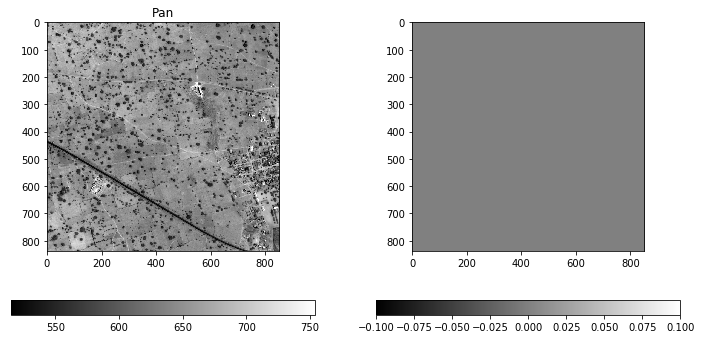

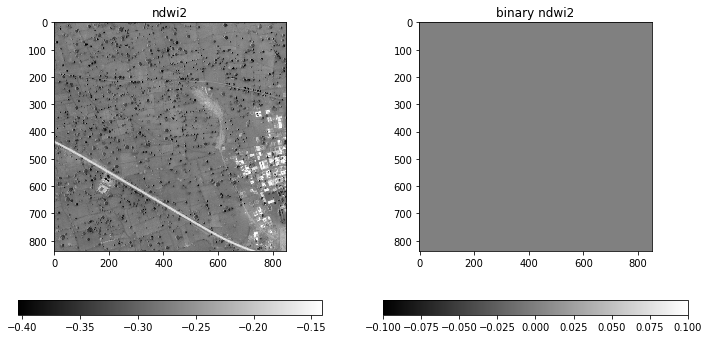

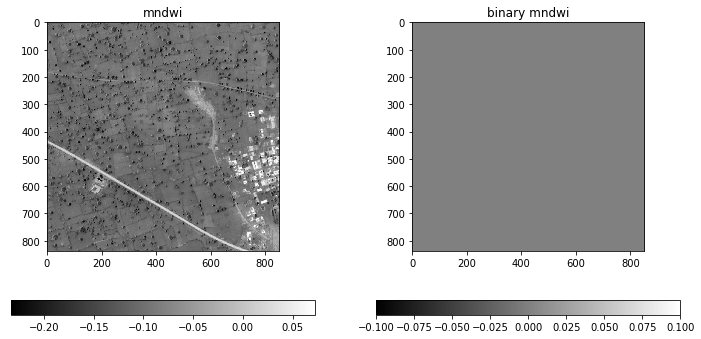

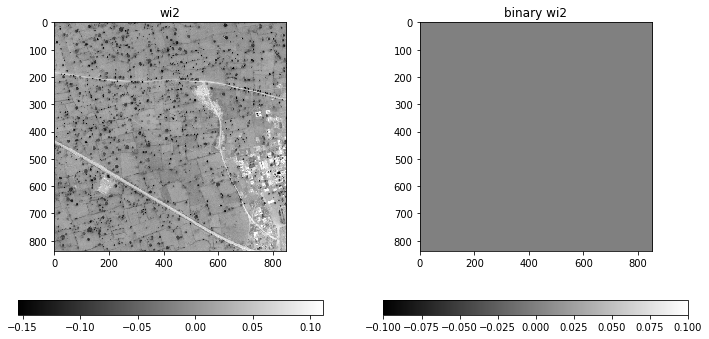

In [11]:
for i, image_id in enumerate(ALL_IMAGE_IDS):
    i += count
    image_id = ALL_IMAGE_IDS[i]
    if image_id not in _cache_wi:
        wi_img = compute_water_indices(image_id)
        _cache_wi[image_id] = wi_img        
        img_pan = get_image_data(image_id, 'pan')            
        img_pan = cv2.resize(img_pan, dsize=(wi_img.shape[1], wi_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        _cache_pan[image_id] = img_pan
        
    wi_img = _cache_wi[image_id]
    img_pan = _cache_pan[image_id]    
    
    print "--", image_id, i, "/", len(ALL_IMAGE_IDS)
    plt_st(12,6)
    plt.subplot(121)
    display_img_1b(img_pan)
    plt.title("Pan")
    plt.subplot(122)
    display_img_1b(water_detector(wi_img))
    m = 1 
    for j in range(wi_img.shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,2, (j) % m + 1)
        plt.title("%s" % channels[j])
        display_img_1b(wi_img[:,:,j])
        
        plt.subplot(1,2, (j) % m + 2)
        t1, t2, size, iters = params[j]
        bin_img = binarize(wi_img[:,:,j], t1, t2, size, iters)
        display_img_1b(bin_img)
        plt.title("binary %s" % channels[j])
    break
count += 1

In [16]:
water_test = [
    "6080_4_4",    "6080_4_2",    "6080_4_3",     "6080_4_0",    "6080_4_1",
    "6090_4_3",    "6080_2_4",    "6080_2_0",     "6080_2_1",    "6080_2_2",
    "6080_2_3",    "6080_0_2",    "6080_0_3",     "6080_0_0",    "6080_0_4",
    "6170_1_4",    "6150_3_4",    "6020_0_4",     "6020_4_3",    "6150_2_4",
    "6080_3_1",    "6100_2_2",    "6080_3_0"
]

others = [
    "6040_2_2", "6110_4_0", "6110_1_2"
]

In [13]:
_cache_wi = {}
_cache_pan = {}

In [14]:
count = 1
# dataset = water_train
dataset = others

-- 6110_1_2 2 / 3


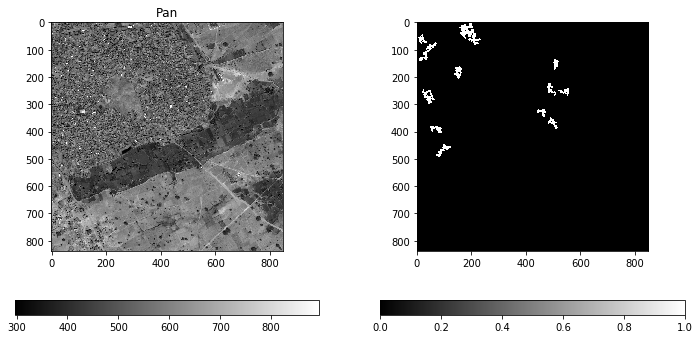

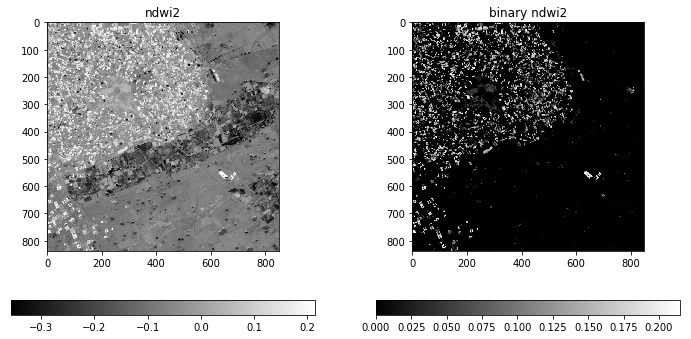

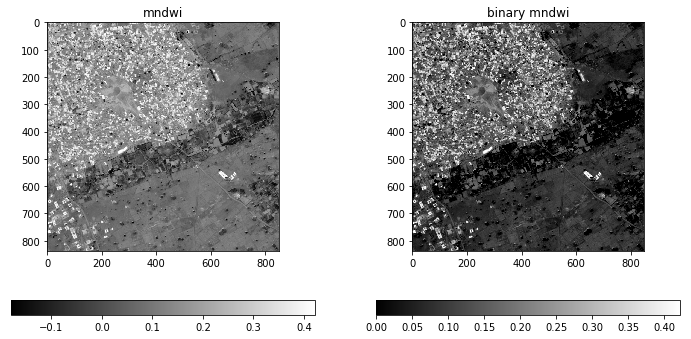

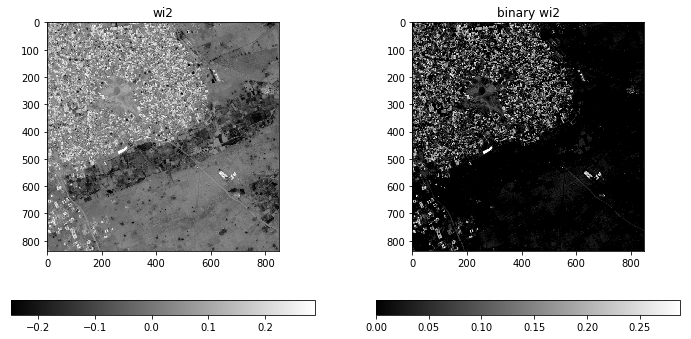

In [16]:
params = {    
    0: (0.2, 999, 20, 1),
    1: (0.2, 999, 20, 1),
    2: (0.2, 999, 20, 1),
    3: (0.2, 999, 20, 1),
    4: (0.5, 999, 20, 1),
}

for i, image_id in enumerate(dataset):
    i += count
    image_id = dataset[i]
    if image_id not in _cache_wi:
        wi_img = compute_water_indices(image_id)
        _cache_wi[image_id] = wi_img        
        img_pan = get_image_data(image_id, 'pan')            
        img_pan = cv2.resize(img_pan, dsize=(wi_img.shape[1], wi_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        _cache_pan[image_id] = img_pan
        
    wi_img = _cache_wi[image_id]
    img_pan = _cache_pan[image_id]    
    
    print "--", image_id, i, "/", len(dataset)
    plt_st(12,6)
    plt.subplot(121)
    display_img_1b(img_pan)
    plt.title("Pan")
    plt.subplot(122)
    display_img_1b(water_detector(wi_img))
    m = 1 
    for j in range(wi_img.shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,2, (j) % m + 1)
        plt.title("%s" % channels[j])
        display_img_1b(wi_img[:,:,j])
        
        plt.subplot(1,2, (j) % m + 2)
        t1, t2, size, iters = params[j]
        bin_img = _relu(wi_img[:,:,j])
        #bin_img = binarize(wi_img[:,:,j], t1, t2, size, iters)
        display_img_1b(bin_img)
        plt.title("binary %s" % channels[j])
    break
count += 1

## Run detector on all images

In [17]:
from image_utils import imwrite
from data_utils import GENERATED_LABELS
import os

In [18]:
for i, image_id in enumerate(ALL_IMAGE_IDS):
    print "--", image_id, i+1, "/", len(ALL_IMAGE_IDS)
    wi_img = compute_water_indices(image_id)
    water_img = water_detector(wi_img)
    filename = os.path.join(GENERATED_LABELS, image_id + '_water.tif')
    imwrite(filename, water_img[:,:,None])

-- 6120_2_4 1 / 450
-- 6120_2_3 2 / 450
-- 6120_2_2 3 / 450
-- 6120_2_1 4 / 450
-- 6120_2_0 5 / 450
-- 6180_2_4 6 / 450
-- 6180_2_1 7 / 450
-- 6180_2_0 8 / 450
-- 6180_2_3 9 / 450
-- 6180_2_2 10 / 450
-- 6180_0_3 11 / 450
-- 6180_0_2 12 / 450
-- 6180_0_1 13 / 450
-- 6180_0_0 14 / 450
-- 6180_0_4 15 / 450


KeyboardInterrupt: 

In [20]:
from PIL import Image

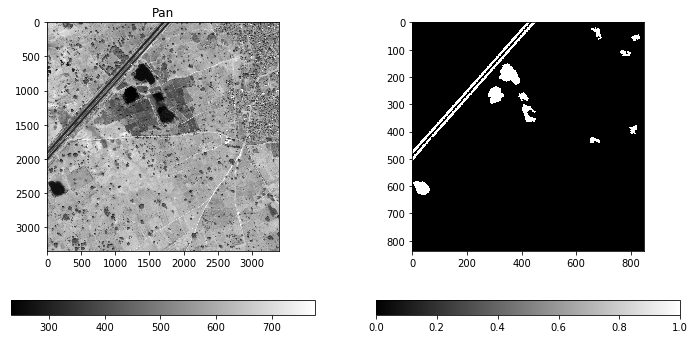

In [22]:
dataset = others
image_id = dataset[np.random.randint(0, len(dataset))]
filename = os.path.join(GENERATED_LABELS, image_id + '_water.tif')
water_img = np.asarray(Image.open(filename))

plt_st(12, 6)
plt.subplot(121)
plt.title("Pan")
display_img_1b(get_image_data(image_id, 'pan'))
plt.subplot(122)
display_img_1b(water_img)